In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [11]:
df = pd.read_csv('data_SEX_Solving.csv')

In [17]:
df['NHOMNOMOI'].value_counts()

NHOMNOMOI
1    84981
2     3894
5     3756
4     1350
3     1290
Name: count, dtype: int64

In [12]:
df.NHOMNOMOI.value_counts()

NHOMNOMOI
1    84981
2     3894
5     3756
4     1350
3     1290
Name: count, dtype: int64

In [13]:
len(df)

95271

In [14]:
df.head()

,MJACCTTYPCD,PHUONG THUC CHO VAY,LOAIKH,SEX,BASE_BAL,DUNO_QD,CURRENCYCD,THOIHAN,DESC_TIME,MJACCTTYPDESC,PARENTORGNAME,LAISUAT,MUCDICHVAY,NHOMNOMOI
0,CNS,TRA GOP,1,1,787127020.0,851714900.0,VND,112,Vay ngan han,Vay Tieu dung,KLB - CN KHANH HOA,12.0,1900-SX-DV Tu t.dung Gia dinh,1
1,CNS,TRA GOP,1,1,333388030.0,142450650.0,VND,240,Vay ngan han,Vay Tieu dung,KLB - CN DA NANG,18.0,1811-CV mua Xe may tra gop,1
2,CNS,TRA GOP,1,1,311014800.0,357000690.0,VND,243,Vay ngan han,Vay Tieu dung,KLB - CN DA NANG,18.0,1870-CV TG Sinh hoat Tieu dung,1
3,CNS,CV TUNG LAN LAI DINH KY,1,1,35600000.0,35600000.0,VND,37,Vay trung han,Vay Tieu dung,KLB - CN KHANH HOA,24.0,1830-CV Sua chua Nha de o,5
4,CNS,TRA GOP,1,1,430174020.0,88246180.0,VND,244,Vay ngan han,Vay Tieu dung,KLB - CN DA NANG,18.0,1870-CV TG Sinh hoat Tieu dung,1


In [15]:
import pandas as pd
import numpy as np

def process_data(df):
    # Tạo bản sao để tránh cảnh báo SettingWithCopyWarning
    df = df.copy()

    # ---------------------------------------------------------
    # 1. XỬ LÝ CURRENCYCD
    # ---------------------------------------------------------
    # Drop hàng có CURRENCYCD = USD
    if 'CURRENCYCD' in df.columns:
        df = df[df['CURRENCYCD'] != 'USD']
        # Xóa cột CURRENCYCD
        df.drop(columns=['CURRENCYCD'], inplace=True)

    # ---------------------------------------------------------
    # 2. XỬ LÝ DESC_TIME VÀ THOIHAN (Phức tạp nhất)
    # ---------------------------------------------------------
    # Ép kiểu THOIHAN về số để tính toán
    df['THOIHAN'] = pd.to_numeric(df['THOIHAN'], errors='coerce')

    # Tạo các điều kiện giữ lại dữ liệu (Filtering Mask)
    
    # a. Vay dai han: Giữ lại nếu (60 < THOIHAN <= 400)
    # Tức là Drop <= 60 hoặc > 400
    mask_dai_han = (df['DESC_TIME'] == 'Vay dai han') & (df['THOIHAN'] > 60) & (df['THOIHAN'] <= 400)

    # b. Vay trung han: Giữ lại nếu (13 <= THOIHAN <= 61)
    mask_trung_han = (df['DESC_TIME'] == 'Vay trung han') & (df['THOIHAN'] >= 13) & (df['THOIHAN'] <= 61)

    # c. Vay ngan han:
    # - Drop >= 367 (Chỉ giữ lại < 367)
    # - Logic giữ lại: [0; 13] HOẶC [30; 366]
    mask_ngan_han_raw = (df['DESC_TIME'] == 'Vay ngan han') & (
        ((df['THOIHAN'] >= 0) & (df['THOIHAN'] <= 13)) | 
        ((df['THOIHAN'] >= 30) & (df['THOIHAN'] <= 366))
    )

    # Áp dụng Filter: Chỉ giữ lại các dòng thỏa mãn 1 trong 3 điều kiện trên
    # Các dòng không thỏa mãn (bao gồm khoảng trống giữa 13-30 của ngắn hạn, hay >400 dài hạn...) sẽ bị drop
    df = df[mask_dai_han | mask_trung_han | mask_ngan_han_raw]

    # d. Xử lý phép tính "Chia 30" cho Vay ngắn hạn trong khoảng [30; 366]
    # Lọc ra các dòng cần chia
    mask_to_divide = (df['DESC_TIME'] == 'Vay ngan han') & (df['THOIHAN'] >= 30) & (df['THOIHAN'] <= 366)
    
    # Thực hiện chia
    df.loc[mask_to_divide, 'THOIHAN'] = (df.loc[mask_to_divide, 'THOIHAN'] / 30).astype(int)

    # ---------------------------------------------------------
    # 3. XỬ LÝ LAISUAT
    # ---------------------------------------------------------
    # Drop > 40
    df['LAISUAT'] = pd.to_numeric(df['LAISUAT'], errors='coerce')
    df = df[df['LAISUAT'] <= 40]

    # ---------------------------------------------------------
    # 4. XỬ LÝ MUCDICVAY
    # ---------------------------------------------------------
    # Tách lấy 4 ký tự đầu tiên
    df['MUCDICHVAY'] = df['MUCDICHVAY'].astype(str).str[:4]

    # ---------------------------------------------------------
    # 5. XỬ LÝ PARENTORGNAME
    # ---------------------------------------------------------
    # Lấy toàn bộ ký tự sau chữ "CN "
    # Ví dụ: 'KLB - CN KHANH HOA' -> split ra ['KLB - ', 'KHANH HOA'] -> lấy phần tử số 1
    def extract_branch(name):
        if isinstance(name, str) and 'CN ' in name:
            return name.split('CN ', 1)[1] # 1 nghĩa là chỉ cắt ở chữ CN đầu tiên tìm thấy
        return name # Trả về nguyên gốc nếu không tìm thấy "CN "

    df['PARENTORGNAME'] = df['PARENTORGNAME'].apply(extract_branch)

    return df


df_clean = process_data(df)
print(df_clean.head())

  MJACCTTYPCD      PHUONG THUC CHO VAY  LOAIKH  SEX     BASE_BAL      DUNO_QD  \
0         CNS                  TRA GOP       1    1  787127020.0  851714900.0   
1         CNS                  TRA GOP       1    1  333388030.0  142450650.0   
2         CNS                  TRA GOP       1    1  311014800.0  357000690.0   
3         CNS  CV TUNG LAN LAI DINH KY       1    1   35600000.0   35600000.0   
4         CNS                  TRA GOP       1    1  430174020.0   88246180.0   

   THOIHAN      DESC_TIME  MJACCTTYPDESC PARENTORGNAME  LAISUAT MUCDICHVAY  \
0        3   Vay ngan han  Vay Tieu dung     KHANH HOA     12.0       1900   
1        8   Vay ngan han  Vay Tieu dung       DA NANG     18.0       1811   
2        8   Vay ngan han  Vay Tieu dung       DA NANG     18.0       1870   
3       37  Vay trung han  Vay Tieu dung     KHANH HOA     24.0       1830   
4        8   Vay ngan han  Vay Tieu dung       DA NANG     18.0       1870   

   NHOMNOMOI  
0          1  
1          1  

In [ ]:
for i in range(1,6):
    somaubandau = len(df[df['NHOMNOMOI'] == i])
    somaulucsau = len(df_clean[df_clean['NHOMNOMOI'] == i])
    soluongxoa= somaubandau - somaulucsau
    tyle = soluong / len(df[df['NHOMNOMOI'] == i])

  
    

Đã xóa 1568 dữ liệu nhóm 1, tỷ lệ: 0.018451183205657737
Đã xóa 31 dữ liệu nhóm 2, tỷ lệ: 0.007960965588084233
Đã xóa 4 dữ liệu nhóm 3, tỷ lệ: 0.0031007751937984496
Đã xóa 13 dữ liệu nhóm 4, tỷ lệ: 0.00962962962962963
Đã xóa 367 dữ liệu nhóm 5, tỷ lệ: 0.09771033013844516


In [ ]:
data_list = []
for i in range(1, 6):
    somaubandau = len(df[df['NHOMNOMOI'] == i])
    somaulucsau = len(df_clean[df_clean['NHOMNOMOI'] == i])
    soluongxoa = somaubandau - somaulucsau 
    tyle = soluongxoa / somaubandau
    data_list.append({
        'Nhom': i,
        'So Mau Ban Dau': somaubandau,
        'So Mau Luc Sau': somaulucsau,
        'So Luong Xoa': soluongxoa,
        'Ty Le Xoa': tyle
    })

df_ketqua = pd.DataFrame(data_list)
df_ketqua

,Nhom,So Mau Ban Dau,So Mau Luc Sau,So Luong Xoa,Ty Le Xoa
0,1,84981,83413,1568,0.018451
1,2,3894,3863,31,0.007961
2,3,1290,1286,4,0.003101
3,4,1350,1337,13,0.009630
4,5,3756,3389,367,0.097710


In [ ]:
df_clean[]

In [ ]:
#Null
for col in df.columns:
    print(col)
    print(f"{df[col].isnull().sum()}")

MJACCTTYPCD
0
PHUONG THUC CHO VAY
0
LOAIKH
0
SEX
0
BASE_BAL
0
DUNO_QD
0
CURRENCYCD
0
THOIHAN
0
DESC_TIME
0
MJACCTTYPDESC
0
PARENTORGNAME
0
LAISUAT
0
MUCDICHVAY
0
NHOMNOMOI
0


In [ ]:
df[df['CURRENC'] == ]

In [ ]:
#Nuberic Data & Categorical Data
numeric_data = df.select_dtypes(include=['number']).drop(['LOAIKH', 'SEX', 'NHOMNOMOI'], axis= 1)
categorical_data = df.select_dtypes(include=['object', 'category'])

cols_to_add = ['LOAIKH', 'SEX', 'NHOMNOMOI']
new_cols_df = df[cols_to_add].astype('object')
categorical_data = pd.concat([categorical_data, new_cols_df], axis=1)

numeric_cols = numeric_data.columns
categorical_cols = categorical_data.columns

len(numeric_cols), len(categorical_cols), len(df.columns)


(4, 10, 14)

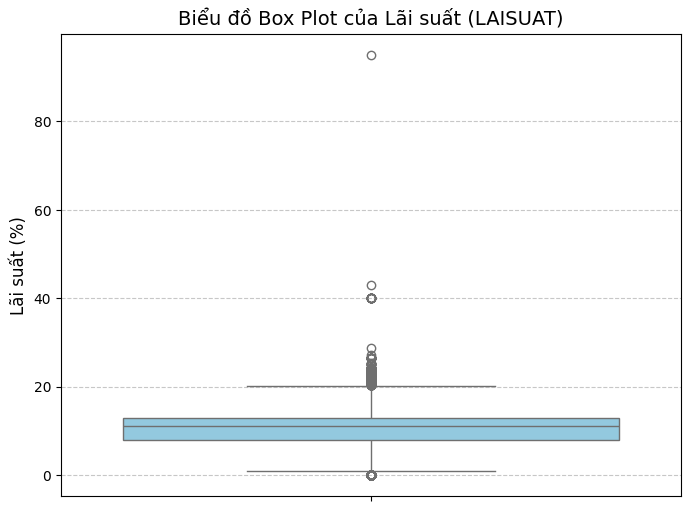

In [123]:
import matplotlib.pyplot as plt
import seaborn as sns

# Thiết lập kích thước biểu đồ
plt.figure(figsize=(8, 6))

# Vẽ Box plot cho cột LAISUAT
# y=df['LAISUAT']: Vẽ theo trục dọc (nếu muốn vẽ ngang thì đổi thành x=...)
sns.boxplot(y=df['LAISUAT'], color='skyblue')

# Thêm tiêu đề và nhãn trục
plt.title('Biểu đồ Box Plot của Lãi suất (LAISUAT)', fontsize=14)
plt.ylabel('Lãi suất (%)', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7) # Thêm lưới ngang cho dễ nhìn

plt.show()

In [133]:
# Lai suat 

df[df['LAISUAT'] > 40]['NHOMNOMOI'].value_counts()

NHOMNOMOI
1    2
Name: count, dtype: int64

In [21]:
numeric_data.head(5), numeric_cols

(      BASE_BAL      DUNO_QD  THOIHAN  LAISUAT
 0  787127020.0  851714900.0      112     12.0
 1  333388030.0  142450650.0      240     18.0
 2  311014800.0  357000690.0      243     18.0
 3   35600000.0   35600000.0       37     24.0
 4  430174020.0   88246180.0      244     18.0,
 Index(['BASE_BAL', 'DUNO_QD', 'THOIHAN', 'LAISUAT'], dtype='object'))

In [134]:
numeric_data.head()

,BASE_BAL,DUNO_QD,THOIHAN,LAISUAT
0,787127020.0,851714900.0,112,12.0
1,333388030.0,142450650.0,240,18.0
2,311014800.0,357000690.0,243,18.0
3,35600000.0,35600000.0,37,24.0
4,430174020.0,88246180.0,244,18.0


In [138]:
df[df['BASE_BAL'] != df['DUNO_QD']]['NHOMNOMOI'].value_counts()

NHOMNOMOI
1    41969
2     2358
5     1733
4      873
3      851
Name: count, dtype: int64

,LOAIKH,SEX,BASE_BAL,DUNO_QD,THOIHAN,LAISUAT,NHOMNOMOI
count,7787.00000,7787.000000,7.787000e+03,7.787000e+03,7787.000000,7787.000000,7787.000000
mean,1.04713,0.638885,1.326516e+09,1.097408e+09,156.419931,11.768202,1.270836
std,0.21193,0.480355,8.768135e+09,7.107091e+09,61.357135,1.209595,0.793776
min,1.00000,0.000000,1.500000e+06,1.000000e+06,61.000000,2.000000,1.000000
25%,1.00000,0.000000,3.000000e+08,2.643000e+08,122.000000,12.000000,1.000000
50%,1.00000,1.000000,5.000000e+08,4.428282e+08,122.000000,12.000000,1.000000
75%,1.00000,1.000000,9.000000e+08,7.701265e+08,244.000000,12.100000,1.000000
max,2.00000,1.000000,3.750000e+11,3.130000e+11,252.000000,40.000000,5.000000


In [139]:
df[df['NHOMNOMOI'] == 5].head()

,MJACCTTYPCD,PHUONG THUC CHO VAY,LOAIKH,SEX,BASE_BAL,DUNO_QD,CURRENCYCD,THOIHAN,DESC_TIME,MJACCTTYPDESC,PARENTORGNAME,LAISUAT,MUCDICHVAY,NHOMNOMOI
3,CNS,CV TUNG LAN LAI DINH KY,1,1,35600000.0,35600000.0,VND,37,Vay trung han,Vay Tieu dung,KLB - CN KHANH HOA,24.0,1830-CV Sua chua Nha de o,5
7,CNS,CV TUNG LAN LAI DINH KY,1,1,90000000.0,90000000.0,VND,12,Vay ngan han,Vay Tieu dung,KLB - CN KHANH HOA,17.4,1870-CV TG Sinh hoat Tieu dung,5
14,CNS,CV TUNG LAN LAI DINH KY,1,1,53360000.0,8360000.0,VND,49,Vay trung han,Vay Tieu dung,KLB - CN KHANH HOA,15.0,1830-CV Sua chua Nha de o,5
23,CNS,CV TUNG LAN LAI DINH KY,1,0,23360000.0,20870000.0,VND,37,Vay trung han,Vay Tieu dung,KLB - CN KHANH HOA,19.2,1830-CV Sua chua Nha de o,5
26,CML,CV TUNG LAN LAI DINH KY,1,0,80000000.0,80000000.0,VND,12,Vay ngan han,Vay Cong Thuong,KLB - CN KHANH HOA,25.2,"0711-Ban buon L.thuc,T.pham",5


In [141]:
df['MJACCTTYPDESC'].value_counts()

MJACCTTYPDESC
Vay Tieu dung      46677
Vay Nong Nghiep    32418
Vay Cong Thuong    16176
Name: count, dtype: int64

In [140]:
df[df['NHOMNOMOI'] == 1].head()

,MJACCTTYPCD,PHUONG THUC CHO VAY,LOAIKH,SEX,BASE_BAL,DUNO_QD,CURRENCYCD,THOIHAN,DESC_TIME,MJACCTTYPDESC,PARENTORGNAME,LAISUAT,MUCDICHVAY,NHOMNOMOI
0,CNS,TRA GOP,1,1,787127020.0,851714900.0,VND,112,Vay ngan han,Vay Tieu dung,KLB - CN KHANH HOA,12.0,1900-SX-DV Tu t.dung Gia dinh,1
1,CNS,TRA GOP,1,1,333388030.0,142450650.0,VND,240,Vay ngan han,Vay Tieu dung,KLB - CN DA NANG,18.0,1811-CV mua Xe may tra gop,1
2,CNS,TRA GOP,1,1,311014800.0,357000690.0,VND,243,Vay ngan han,Vay Tieu dung,KLB - CN DA NANG,18.0,1870-CV TG Sinh hoat Tieu dung,1
4,CNS,TRA GOP,1,1,430174020.0,88246180.0,VND,244,Vay ngan han,Vay Tieu dung,KLB - CN DA NANG,18.0,1870-CV TG Sinh hoat Tieu dung,1
5,CNS,TRA GOP,1,1,178967050.0,289814360.0,VND,366,Vay ngan han,Vay Tieu dung,KLB - CN DA NANG,16.0,1894-Kinh doanh Ca the,1


In [24]:
df[df['THOIHAN'] > 30]

,MJACCTTYPCD,PHUONG THUC CHO VAY,LOAIKH,SEX,BASE_BAL,DUNO_QD,CURRENCYCD,THOIHAN,DESC_TIME,MJACCTTYPDESC,PARENTORGNAME,LAISUAT,MUCDICHVAY,NHOMNOMOI
0,CNS,TRA GOP,1,1,7.871270e+08,8.517149e+08,VND,112,Vay ngan han,Vay Tieu dung,KLB - CN KHANH HOA,12.0,1900-SX-DV Tu t.dung Gia dinh,1
1,CNS,TRA GOP,1,1,3.333880e+08,1.424506e+08,VND,240,Vay ngan han,Vay Tieu dung,KLB - CN DA NANG,18.0,1811-CV mua Xe may tra gop,1
2,CNS,TRA GOP,1,1,3.110148e+08,3.570007e+08,VND,243,Vay ngan han,Vay Tieu dung,KLB - CN DA NANG,18.0,1870-CV TG Sinh hoat Tieu dung,1
3,CNS,CV TUNG LAN LAI DINH KY,1,1,3.560000e+07,3.560000e+07,VND,37,Vay trung han,Vay Tieu dung,KLB - CN KHANH HOA,24.0,1830-CV Sua chua Nha de o,5
4,CNS,TRA GOP,1,1,4.301740e+08,8.824618e+07,VND,244,Vay ngan han,Vay Tieu dung,KLB - CN DA NANG,18.0,1870-CV TG Sinh hoat Tieu dung,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95202,CNS,"CV TUNG LAN GOC, LAI D.KY",1,1,1.850000e+08,1.798700e+08,VND,37,Vay trung han,Vay Tieu dung,KLB - CN SAI GON,8.6,1860-CV CBCNV KLB,1
95229,CNS,"CV TUNG LAN GOC, LAI D.KY",1,0,1.000000e+08,1.500000e+08,VND,61,Vay trung han,Vay Tieu dung,KLB - CN TRA VINH,13.7,"1899-DV Ca nhan,gia dinh khac",1
95235,CNS,THE TIN DUNG,1,1,2.000000e+07,4.164203e+07,VND,37,Vay ngan han,Vay Tieu dung,KLB - CN RACH GIA,0.0,1840-CV master-Visa-JCB card,2
95239,CNS,"CV TUNG LAN GOC, LAI D.KY",1,0,4.900000e+08,4.900000e+08,VND,244,Vay dai han,Vay Tieu dung,KLB - CN BINH THUAN,8.9,1870-CV TG Sinh hoat Tieu dung,1


In [20]:
df[df['DUNO_QD'] > df['BASE_BAL']]['NHOMNOMOI'].value_counts()

NHOMNOMOI
1    17533
2      817
4      362
3      324
5      292
Name: count, dtype: int64

In [3]:
df_copy = df.copy()
df_copy['ratio'] = df_copy['DUNO_QD']/df_copy['BASE_BAL']
df_ratio = df_copy[['ratio','NHOMNOMOI']]
df_ratio.describe().round(3)

,ratio,NHOMNOMOI
count,95271.000,95271.000
mean,109.887,1.268
std,28390.348,0.884
min,0.000,1.000
25%,0.931,1.000
50%,1.000,1.000
75%,1.000,1.000
max,8760489.000,5.000


In [4]:
df_ratio[df_ratio['ratio'] == df_ratio['ratio'].max() ]

,ratio,NHOMNOMOI
14205,8760489.0,1


In [5]:
idx_max = df_ratio['ratio'].idxmax()

# Bước 2: Xóa dòng đó
df_clean = df_ratio.drop(idx_max)


In [6]:
a= df_clean[df_clean['ratio'] <= 2]

In [7]:
a.NHOMNOMOI.value_counts()

NHOMNOMOI
1    73680
5     3554
2     3419
4     1108
3     1081
Name: count, dtype: int64

In [16]:
a[(a['ratio'] ==1 )]['NHOMNOMOI'].value_counts()

NHOMNOMOI
1    43012
5     2023
2     1536
4      477
3      439
Name: count, dtype: int64

In [10]:
df.NHOMNOMOI.value_counts()

NHOMNOMOI
1    84981
2     3894
5     3756
4     1350
3     1290
Name: count, dtype: int64

C:\Users\PC\AppData\Local\Temp\ipykernel_2972\2090016847.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='NHOMNOMOI', y='ratio', data=a, palette='viridis')


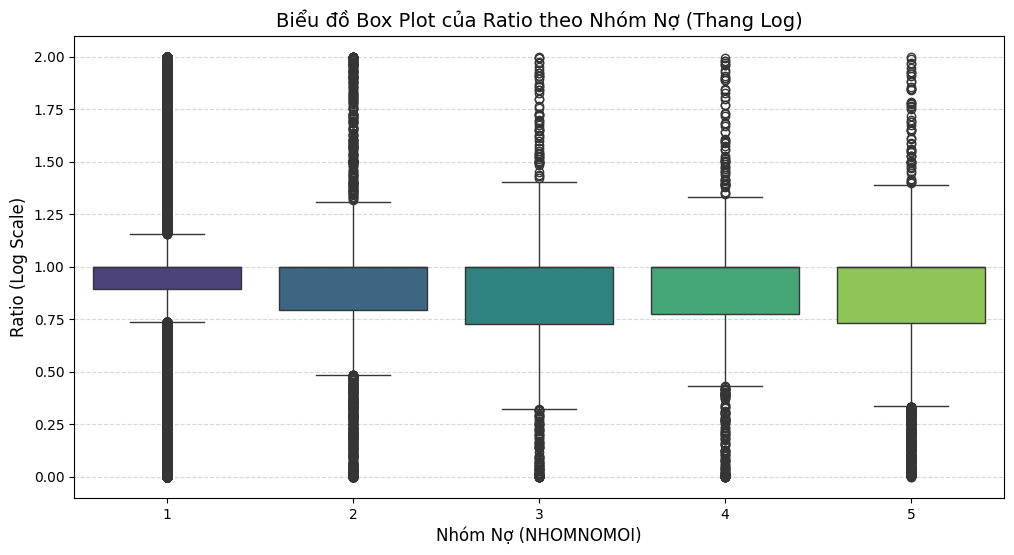

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# Vẽ Box plot
sns.boxplot(x='NHOMNOMOI', y='ratio', data=a, palette='viridis')

# Chuyển trục Y sang thang log để nhìn rõ các nhóm

plt.title('Biểu đồ Box Plot của Ratio theo Nhóm Nợ (Thang Log)', fontsize=14)
plt.xlabel('Nhóm Nợ (NHOMNOMOI)', fontsize=12)
plt.ylabel('Ratio (Log Scale)', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.show()

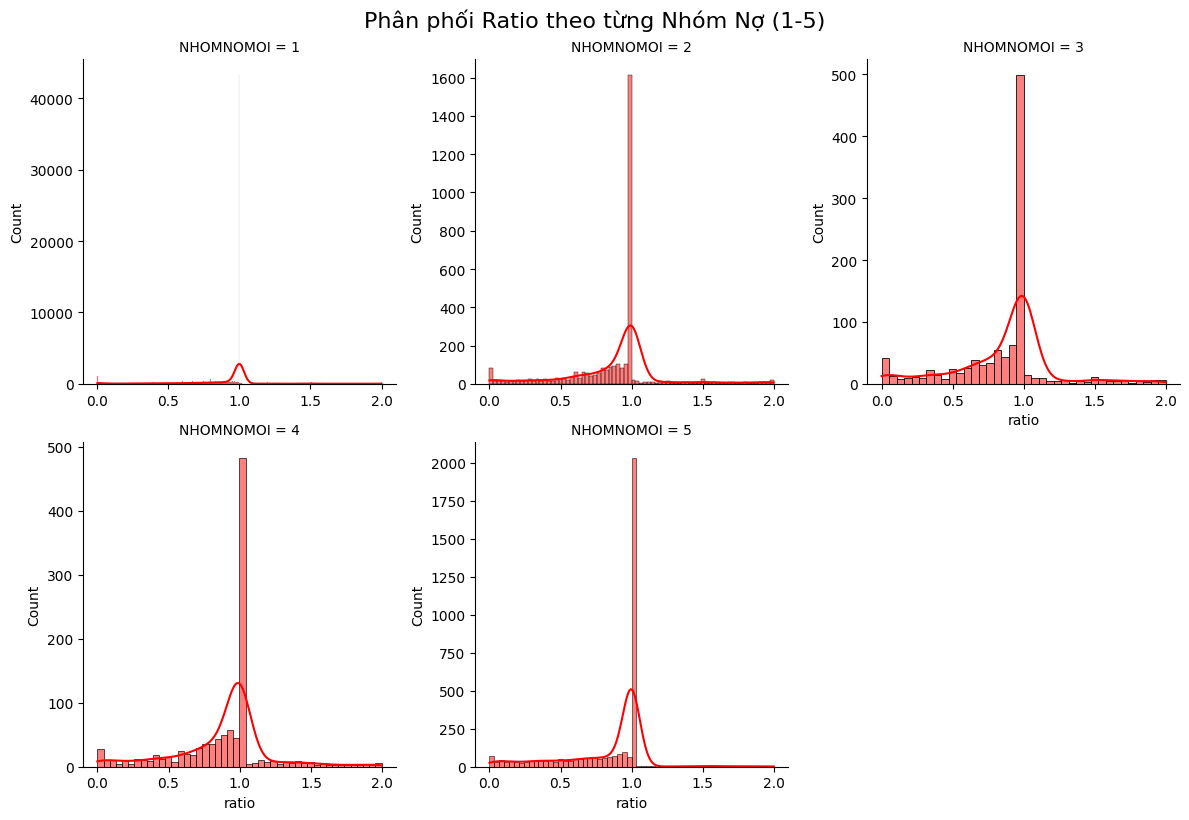

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

# Sử dụng FacetGrid để chia nhỏ biểu đồ theo cột 'NHOMNOMOI'
# col_wrap=3: Ngắt dòng sau mỗi 3 biểu đồ
# sharex=False, sharey=False: Để trục tung/hoành tự co giãn theo từng nhóm (vì Nhóm 1 rất cao, Nhóm 5 rất thấp)
g = sns.FacetGrid(a, col="NHOMNOMOI", col_wrap=3, height=4, sharex=False, sharey=False)
g.map(sns.histplot, "ratio", kde=True, color="red")

# Thêm tiêu đề chung
g.fig.suptitle('Phân phối Ratio theo từng Nhóm Nợ (1-5)', y=1.02, fontsize=16)

plt.show()

In [60]:
df_daihan = df[df['DESC_TIME'] == 'Vay dai han']
df_daihan.describe()

,LOAIKH,SEX,BASE_BAL,DUNO_QD,THOIHAN,LAISUAT,NHOMNOMOI
count,7795.000000,7795.000000,7.795000e+03,7.795000e+03,7795.000000,7795.000000,7795.000000
mean,1.047338,0.638871,1.327656e+09,1.097790e+09,156.387941,11.767866,1.270558
std,0.212375,0.480359,8.765484e+09,7.104099e+09,61.844233,1.209820,0.793416
min,1.000000,0.000000,1.500000e+06,1.000000e+06,8.000000,2.000000,1.000000
25%,1.000000,0.000000,3.000000e+08,2.642500e+08,122.000000,12.000000,1.000000
50%,1.000000,1.000000,5.000000e+08,4.427200e+08,122.000000,12.000000,1.000000
75%,1.000000,1.000000,9.000000e+08,7.701265e+08,244.000000,12.100000,1.000000
max,2.000000,1.000000,3.750000e+11,3.130000e+11,779.000000,40.000000,5.000000


In [71]:
df_daihan[(df_daihan['THOIHAN'] < 60)|(df_daihan['THOIHAN'] > 400)]['NHOMNOMOI'].value_counts()

NHOMNOMOI
1    8
Name: count, dtype: int64

In [25]:
df_trunghan = df[df['DESC_TIME'] == 'Vay trung han']
df_trunghan.describe()

,LOAIKH,SEX,BASE_BAL,DUNO_QD,THOIHAN,LAISUAT,NHOMNOMOI
count,12968.000000,12968.000000,1.296800e+04,1.296800e+04,12968.000000,12968.000000,12968.000000
mean,1.019818,0.643816,4.986103e+08,3.864766e+08,52.471931,12.645551,1.639574
std,0.139380,0.478889,6.912545e+09,5.663765e+09,15.578047,2.158630,1.373418
min,1.000000,0.000000,3.325000e+05,5.000000e+04,0.000000,1.030000,1.000000
25%,1.000000,0.000000,1.000000e+08,6.443030e+07,37.000000,11.600000,1.000000
50%,1.000000,1.000000,2.030000e+08,1.404000e+08,61.000000,12.000000,1.000000
75%,1.000000,1.000000,3.500000e+08,2.615250e+08,61.000000,13.700000,1.000000
max,2.000000,1.000000,3.850000e+11,2.900000e+11,244.000000,95.000000,5.000000


In [26]:
df_trunghan[(df_trunghan['THOIHAN'] > 1)&(df_trunghan['THOIHAN'] < 6)]['NHOMNOMOI'].value_counts()

NHOMNOMOI
1    6
Name: count, dtype: int64

In [ ]:
# 13 - 61 
df_trunghan[(df_trunghan['THOIHAN'] > 61)|(df_trunghan['THOIHAN'] < 13)]['NHOMNOMOI'].value_counts()

NHOMNOMOI
1    263
5    164
2     13
3      2
4      1
Name: count, dtype: int64

In [76]:
# 13 - 61 
df_trunghan[(df_trunghan['THOIHAN'] == df_trunghan['THOIHAN'].max())|(df_trunghan['THOIHAN'] == df_trunghan['THOIHAN'].min())]

,MJACCTTYPCD,PHUONG THUC CHO VAY,LOAIKH,SEX,BASE_BAL,DUNO_QD,CURRENCYCD,THOIHAN,DESC_TIME,MJACCTTYPDESC,PARENTORGNAME,LAISUAT,MUCDICHVAY,NHOMNOMOI
7763,CNS,"CV TUNG LAN GOC, LAI D.KY",1,1,3.000000e+08,256250000.0,VND,244,Vay trung han,Vay Tieu dung,KLB - CN HAU GIANG,9.30,"1822-CV mua,nhan,nhuong BDS",1
9377,CNS,"CV TUNG LAN GOC, LAI D.KY",1,0,4.500000e+08,382500000.0,VND,244,Vay trung han,Vay Tieu dung,KLB - CN BINH DUONG,12.20,"1822-CV mua,nhan,nhuong BDS",1
11637,CNS,"CV TUNG LAN GOC, LAI D.KY",1,0,5.990000e+08,526800000.0,VND,244,Vay trung han,Vay Tieu dung,KLB - CN CAN THO,11.35,"1822-CV mua,nhan,nhuong BDS",5
18549,MTG,CV LAI GIU LAI MOT PHAN,1,1,6.000000e+07,60000000.0,VND,0,Vay trung han,Vay Nong Nghiep,KLB - CN RACH GIA,17.40,0111-Nong nghiep,5
20465,MTG,CV LAI GIU LAI MOT PHAN,1,1,3.500000e+07,35000000.0,VND,0,Vay trung han,Vay Nong Nghiep,KLB - CN RACH GIA,20.40,0111-Nong nghiep,5
21545,CML,CV LAI GIU LAI MOT PHAN,1,1,1.300000e+08,130000000.0,VND,0,Vay trung han,Vay Cong Thuong,KLB - CN BAC LIEU,13.68,0710-HD Thuong nghiep,5
36819,CNS,"CV TUNG LAN GOC, LAI D.KY",1,1,4.600000e+08,439496744.0,VND,244,Vay trung han,Vay Tieu dung,KLB - CN DONG NAI,12.00,"1822-CV mua,nhan,nhuong BDS",2
80879,CML,"CV TUNG LAN GOC, LAI D.KY",1,0,1.000000e+09,991800000.0,VND,244,Vay trung han,Vay Cong Thuong,KLB - CN RACH GIA,12.00,"1822-CV mua,nhan,nhuong BDS",1


In [ ]:
df_nganhan = df[df['DESC_TIME'] == 'Vay ngan han']
df_nganhan.describe()


,LOAIKH,SEX,BASE_BAL,DUNO_QD,THOIHAN,LAISUAT,NHOMNOMOI
count,74508.000000,74508.000000,7.450800e+04,7.450800e+04,74508.000000,74508.000000,74508.000000
mean,1.012415,0.645568,2.641608e+08,2.686439e+08,28.874591,8.284523,1.203267
std,0.110729,0.478344,2.654932e+09,2.647603e+09,52.575158,5.797783,0.759517
min,1.000000,0.000000,2.000000e+00,1.000000e+00,-11.000000,0.000000,1.000000
25%,1.000000,0.000000,1.391921e+07,2.224335e+07,12.000000,0.000000,1.000000
50%,1.000000,1.000000,1.000000e+08,1.000000e+08,12.000000,11.100000,1.000000
75%,1.000000,1.000000,2.500000e+08,2.500000e+08,37.000000,12.900000,1.000000
max,2.000000,1.000000,2.960000e+11,2.960000e+11,1225.000000,40.000000,5.000000


In [108]:
len(df_nganhan)

74508

In [ ]:
# 15 - 366(/30)
df_nganhan[(df_nganhan['THOIHAN'] >= 30) & (df_nganhan['THOIHAN'] <= 366)]['NHOMNOMOI'].value_counts()

NHOMNOMOI
1    22340
2     1054
5      452
4      423
3      422
Name: count, dtype: int64

In [ ]:
# 15 - 366(/30)
df_nganhan[(df_nganhan['THOIHAN'] >= 0) & (df_nganhan['THOIHAN'] <= 13)]['NHOMNOMOI'].value_counts()

NHOMNOMOI
1    44042
2     1591
5     1260
4      515
3      477
Name: count, dtype: int64

In [117]:
df_nganhan[((df_nganhan['THOIHAN'] > 13) & (df_nganhan['THOIHAN'] < 28))]['NHOMNOMOI'].value_counts()
# |(df_nganhan['THOIHAN'] > 366)|(df_nganhan['THOIHAN'] < 0) 

NHOMNOMOI
1    728
5    199
2     15
4     10
3      2
Name: count, dtype: int64

In [113]:
df_nganhan[(df_nganhan['THOIHAN'] == 0)]['NHOMNOMOI'].value_counts()

NHOMNOMOI
1    372
4     15
5     10
2      9
Name: count, dtype: int64

C:\Users\PC\AppData\Local\Temp\ipykernel_17868\2337922158.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='DESC_TIME', y='THOIHAN', data=df_clean, palette='Set2')


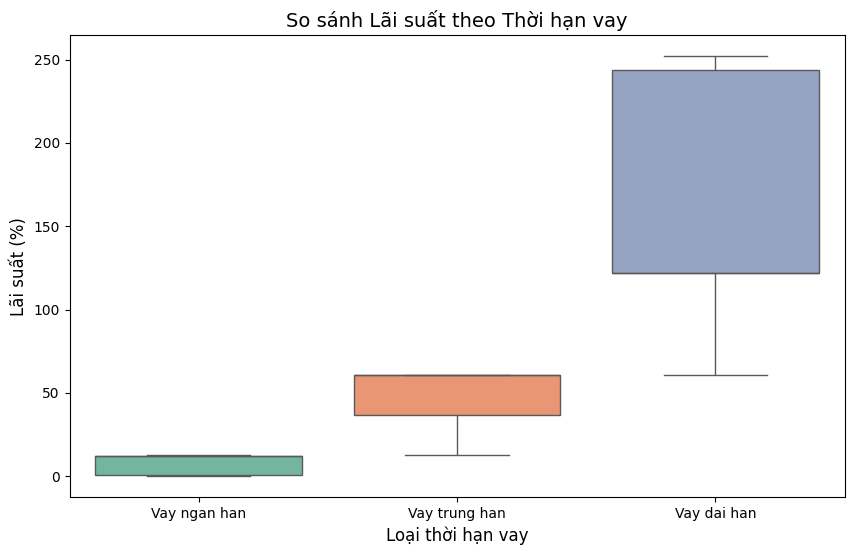

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

# Thiết lập kích thước biểu đồ
plt.figure(figsize=(10, 6))

# Vẽ Box plot
# x: Cột định tính (phân loại nhóm)
# y: Cột định lượng (giá trị cần so sánh)
sns.boxplot(x='DESC_TIME', y='THOIHAN', data=df_clean, palette='Set2')

# Thêm tiêu đề và nhãn
plt.title('So sánh Lãi suất theo Thời hạn vay', fontsize=14)
plt.xlabel('Loại thời hạn vay', fontsize=12)
plt.ylabel('Lãi suất (%)', fontsize=12)

plt.show()

In [ ]:
df_clean['NHOMNOMOI'].value_counts()


NHOMNOMOI
1    83413
2     3863
5     3389
4     1337
3     1286
Name: count, dtype: int64

In [18]:
# Lưu file với tên 'du_lieu_sach.csv'
df_clean.to_csv('xuly1.csv', index=False)

c:\Users\PC\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
c:\Users\PC\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


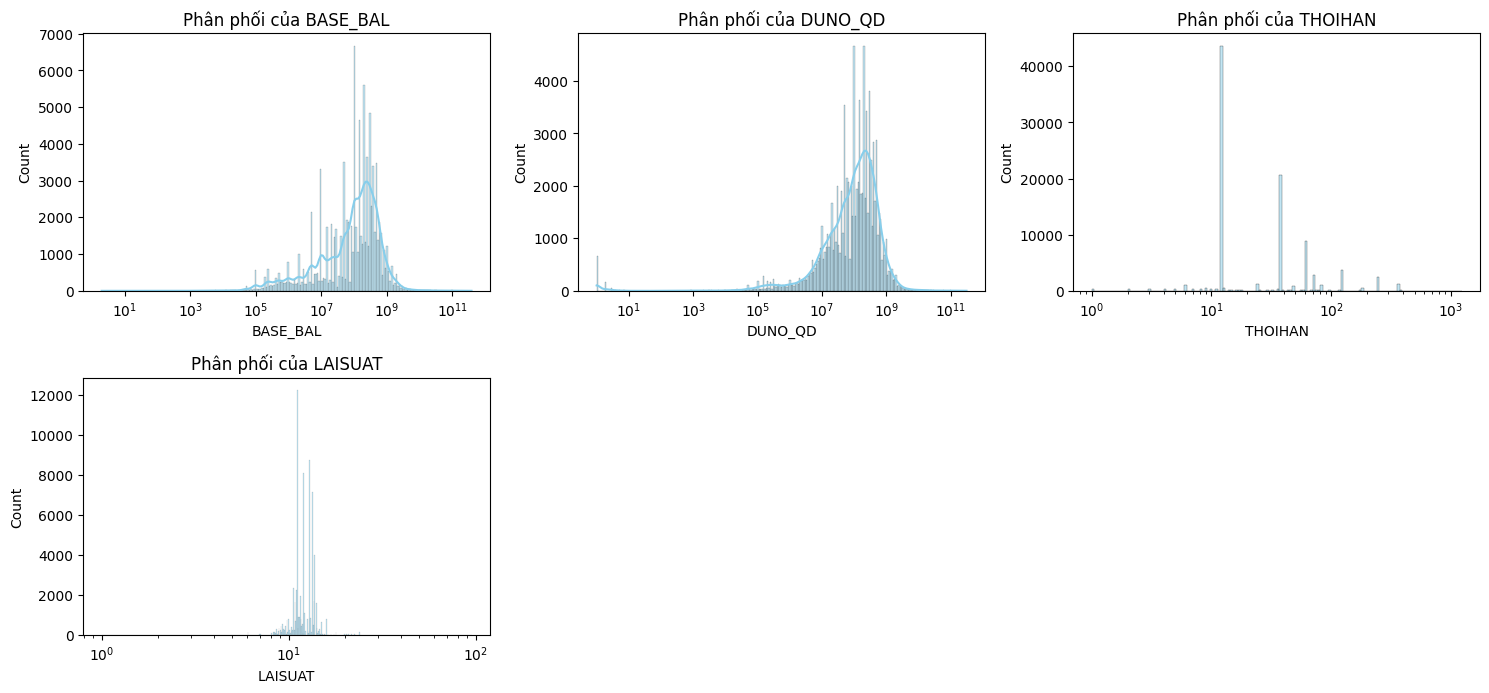

In [26]:
plt.figure(figsize=(15, 10))

for i, col in enumerate(numeric_cols, 1):
    plt.subplot(3, 3, i) 
    sns.histplot(df[col], kde=True, color='skyblue', log_scale= True) 
    plt.title(f'Phân phối của {col}')
    plt.tight_layout()

plt.show()

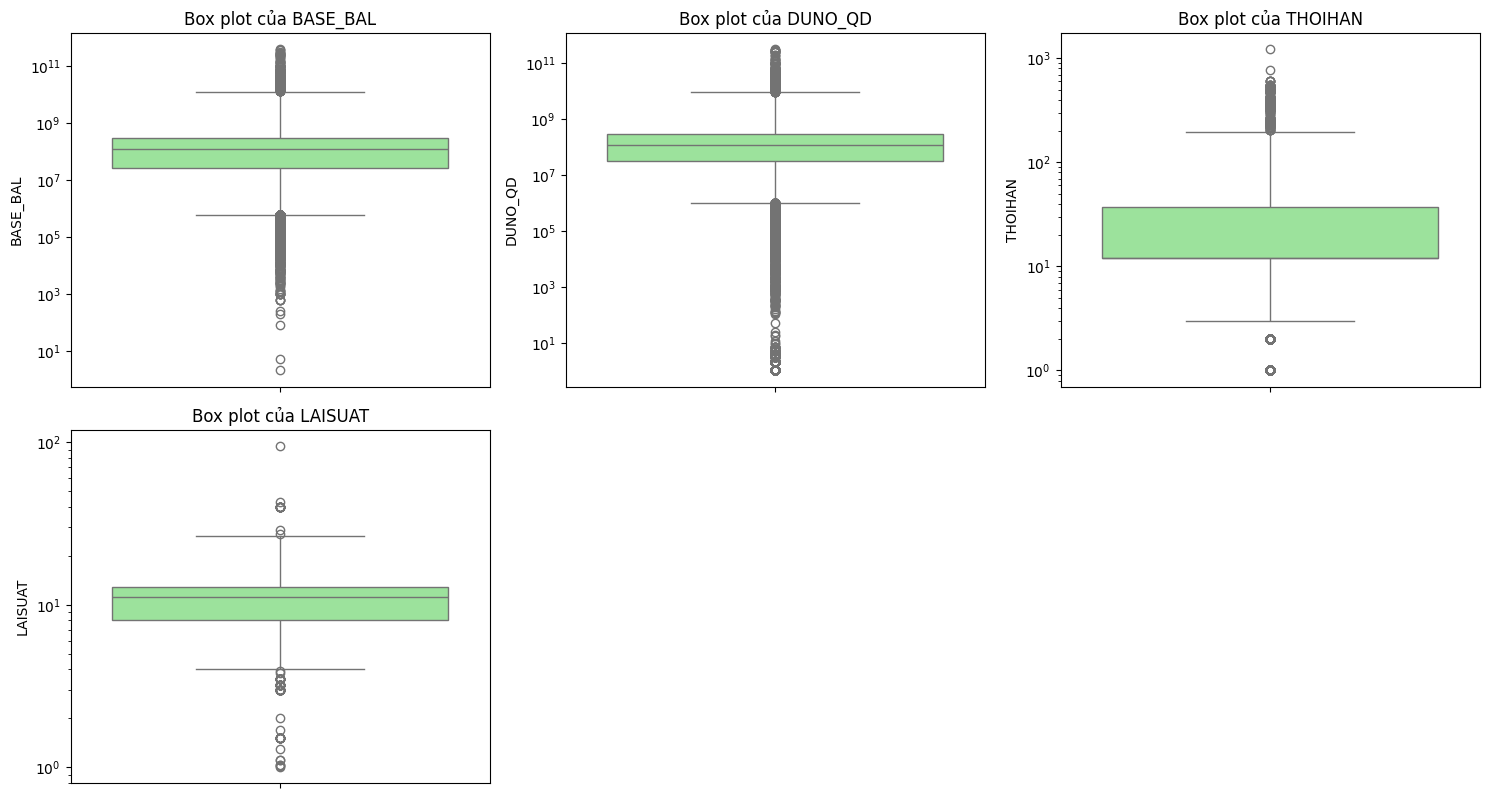

In [ ]:
plt.figure(figsize=(15, 12))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(y=df[col], color='lightgreen')
    plt.title(f'Box plot của {col}')
    plt.tight_layout()

plt.show()

In [39]:
categorical_data.head()

,MJACCTTYPCD,PHUONG THUC CHO VAY,CURRENCYCD,DESC_TIME,MJACCTTYPDESC,PARENTORGNAME,MUCDICHVAY,LOAIKH,SEX,NHOMNOMOI
0,CNS,TRA GOP,VND,Vay ngan han,Vay Tieu dung,KLB - CN KHANH HOA,1900-SX-DV Tu t.dung Gia dinh,1,1,1
1,CNS,TRA GOP,VND,Vay ngan han,Vay Tieu dung,KLB - CN DA NANG,1811-CV mua Xe may tra gop,1,1,1
2,CNS,TRA GOP,VND,Vay ngan han,Vay Tieu dung,KLB - CN DA NANG,1870-CV TG Sinh hoat Tieu dung,1,1,1
3,CNS,CV TUNG LAN LAI DINH KY,VND,Vay trung han,Vay Tieu dung,KLB - CN KHANH HOA,1830-CV Sua chua Nha de o,1,1,5
4,CNS,TRA GOP,VND,Vay ngan han,Vay Tieu dung,KLB - CN DA NANG,1870-CV TG Sinh hoat Tieu dung,1,1,1


In [40]:
for col in categorical_cols:
    a= categorical_data[col].value_counts()
    print(a)
    print(len(a))
    print('---------------------------')

MJACCTTYPCD
CNS    46677
MTG    32418
CML    16176
Name: count, dtype: int64
3
---------------------------
PHUONG THUC CHO VAY
CV TUNG LAN LAI DINH KY      47661
THE TIN DUNG                 23183
CV TUNG LAN GOC, LAI D.KY    19865
TRA GOP                       1817
CV THAU CHI                   1454
CV LAI GIU LAI MOT PHAN        882
CO CAU NO COVID 19             144
CV LUAN CHUYEN VND             141
CV RDF GOC, LAI D.KY           115
CV RDF LAI DINH KY               5
CV MLF LAI DINH KY               4
Name: count, dtype: int64
11
---------------------------
CURRENCYCD
VND    95234
USD       37
Name: count, dtype: int64
2
---------------------------
DESC_TIME
Vay ngan han     74508
Vay trung han    12968
Vay dai han       7795
Name: count, dtype: int64
3
---------------------------
MJACCTTYPDESC
Vay Tieu dung      46677
Vay Nong Nghiep    32418
Vay Cong Thuong    16176
Name: count, dtype: int64
3
---------------------------
PARENTORGNAME
KLB - CN RACH GIA             21602
KLB - CN

# Tiền xử lý dữ liệu


In [ ]:
# Drop hàng 

# Drop cột